In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import gc
from multiprocessing import Process, Queue

import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import multiprocessing as mp

pd.set_option('display.max_rows', 100)

store_stocks_dict = dict()
store_indexes_dict = dict()

## Loading and utils

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    #os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip mstcgl.zip -d data/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_data("WIG20").index.max().strftime(format = "%Y-%m-%d")}')


def update_indexes():
    os.system("rm mstzgr*.zip")
    #os.system("rm mstzgr.zip -d data_for/")
    os.system("wget https://moja.info.bossa.pl/pub/indzagr/mstock/mstzgr.zip")
    os.system("rm -rf data_for/*")
    os.system("unzip mstzgr.zip -d data_for/")

    print(f'Updated {date.today()}, max actual date: \
    {prepare_index("NIKKEI").index.max().strftime(format = "%Y-%m-%d")}')


def prepare_data(paper):

    if 'mst' in paper:
        paper = str(paper).rstrip('.mst')

    try:
        df = store_stocks_dict[paper].copy()
    except:
        df = pd.read_csv(f'data/{paper}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_stocks_dict[paper] = df.copy()

    return df


def prepare_index(indeks):

    if 'mst' in indeks:
        indeks = str(indeks).rstrip('.mst')

    try:
        df = store_indexes_dict[indeks].copy()
    except:
        df = pd.read_csv(f'data_for/{indeks}.mst')

        df.columns = [str(c).replace('<', '') for c in df.columns]
        df.columns = [str(c).replace('>', '') for c in df.columns]

        df.loc[:, 'DTYYYYMMDD'] = pd.to_datetime(df.loc[:, 'DTYYYYMMDD'],
                                                 format='%Y%m%d')

        df = df.set_index('DTYYYYMMDD')

        store_indexes_dict[indeks] = df.copy()

    return df

watch = ['PZU',
         'AMREST',
         'KGHM', 
         'ASSECOSEE', 
         'NORTCOAST', 
         'CDPROJEKT', 
         'VOTUM', 
         'NEWAG', 
         'KRUSZWICA', 
         'INTERAOLT', 
         'PLAY', 
         'ARCHICOM', 
         'LPP', 
         'ARCTIC', 
         'PGNIG',
        'TAURONPE', 
         'PKOBP', 
         'JSW',
        'INTERCARS',
        'BIOMEDLUB',
        'PKOBP',
        'PEKAO',
        'SUNEX',
        'INTERCARS',
        'WIELTON']

watch_af = ['KGHM',
            'KRUK', 
            'PKNORLEN',
            'ENEA',
            'MBANK', 
            'PKOBP', 
            'WIELTON']

In [5]:
update_indexes()

Updated 2020-04-17, max actual date:     2020-04-16


In [6]:
update_stocks()

Updated 2020-04-17, max actual date:     2020-04-16


In [4]:
all_stocks = os.listdir('data/')
all_indekses = os.listdir('data_for/')
print(
    f'no of all available stock: {len(all_stocks)} and indexes: {len(all_indekses)}'
)

no of all available stock: 1966 and indexes: 23


In [5]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

## Single plot

### Plot code

In [164]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        return 'Nothing to show!'

    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) 
                         / plot_df_vol_close.std()) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] 
                              == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.1, 
           plot_range_min, plot_range_max, 
           linestyles='--', 
           colors='orange')
    
    plt.xticks(rotation=15)
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'min + 20%',
               'volumen'])
    plt.show()
    
def prepare_stats_forone(papier, before_crises, big_drop_date):
    
    df = prepare_data(papier)
    df = df.loc[df.index >= '2020-01-01',:]
    
    current = df.tail(1).CLOSE

    
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= 
                                df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 
                                'CLOSE']
    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    
    #dates
    date_max_after_drop = df.loc[df.loc[:,'CLOSE'] == data_max_after_drop,:].index
    
    return (current, data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max,
           date_max_after_drop)

### Just plot

In [169]:
[a for a in all_stocks if 'PEKAO' in a]

['PEKAO.mst']

In [173]:
papier = 'PKOBP'

In [174]:
#plot_paper(papier,'2008-07-15','2008-11-15')

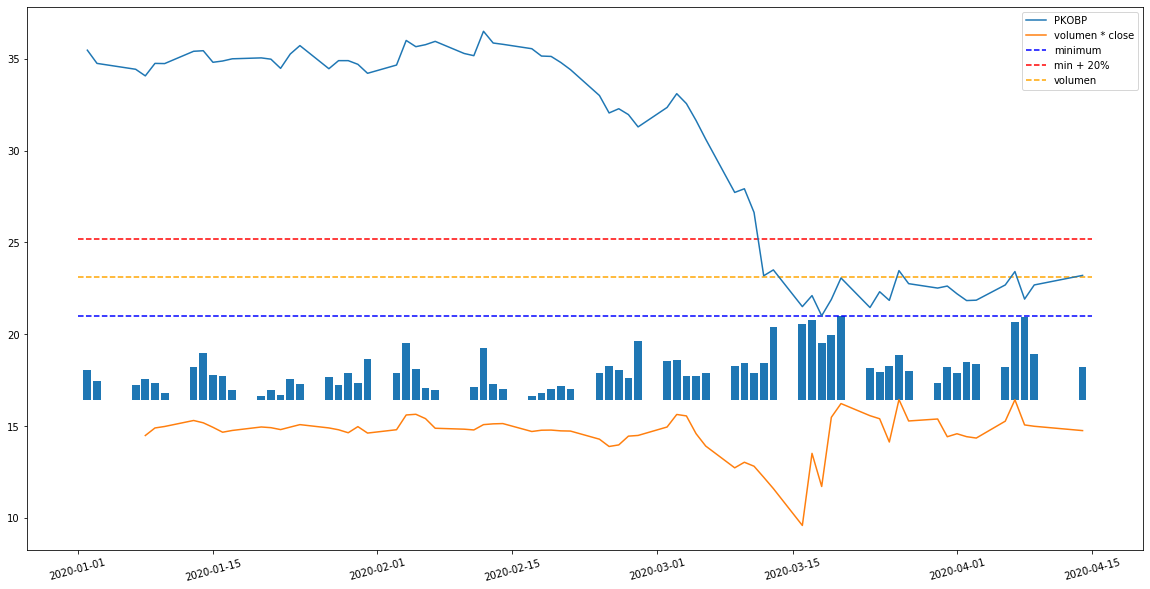

In [175]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [145]:
(current,
data_max_before_crisis,
 data_crises_min,
 data_max_after_drop,
 data_min_after_max,
date_max_after_drop) = prepare_stats_forone(papier, before_crises, big_drop_date)

In [146]:
print(f'Paper: {papier}, currently at {current[0]}, with potential \
{round(data_max_before_crisis*100/current[0]-100, 2)}% to top')
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}, at {date_max_after_drop[0]}')
print(f'Stats after Max: {data_min_after_max.values}')

Paper: PLAY, currently at 33.8, with potential 12.43% to top
Max before crisis: 38.0
Crisis bottom: 25.94
Max after crisis drop: 33.8, at 2020-04-09 00:00:00
Stats after Max: [33.8]


## Skaner

In [6]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = [
    'ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
    'crisis_bottom', 'max_after_crisis', 'max_before_crisis'
]

### All papers

In [7]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_stocks):
    
    df = prepare_data(w)
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1966/1966 [00:12<00:00, 160.64it/s]


In [8]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_potential'] = round((skaner_df.loc[:,'max_before_crisis'] * 100) / skaner_df.loc[:,'current'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [9]:
skaner_df_see = skaner_df.loc[
    (skaner_df.growth_quarter > 0) 
        #& (skaner_df.growth_mid > 0) 
        #& (skaner_df.drop_current < 0) 
        & (skaner_df.growth_current > 0)
                              ,:].sort_values('drop_current', ascending=True)

In [10]:
skaner_df_see = skaner_df_see.loc[
    skaner_df_see.ticker.apply(lambda x: 
                               False if ('RCFL' in x) 
                               | ('INTLGLD' in x) 
                               | ('RCFS' in x)
                               | ('INTL' in x)
                               | ('INTS' in x)
                               | ('RCTL' in x)
                               | ('BETA' in x)
                               | ('RCL' in x) else True).values,]

In [11]:
skaner_df_see.shape

(237, 14)

## Monitoring

In [89]:
to_monitor_list = ['ASBIS', 'UNIMOT',
            'CLNPHARMA', 'SUNEX', 
            'ELKOP', 'ABPL', 
            'MLSYSTEM',
            'AMBRA', 'INTERAOLT', 
            'LENA', 'ARCHICOM', 
            'KREC', 'INTERCARS', 'WIRTUALNA',
            'PLAY', 'MOSTALPLC', 'WIELTON']

In [90]:
df_merged = prepare_data(to_monitor_list[0]).loc[:,['CLOSE', 'TICKER', 'VOL']].copy()
df_merged = df_merged.loc[df_merged.index >= '2020-01-01'].copy()
df_merged.loc[:,'CLOSE'] = ((df_merged.loc[:,'CLOSE'] - df_merged.loc[:,'CLOSE'].mean()) 
                            / df_merged.loc[:,'CLOSE'].std())
df_merged.loc[:,'VOL'] = ((df_merged.loc[:,'VOL'] - df_merged.loc[:,'VOL'].mean()) 
                            / df_merged.loc[:,'VOL'].std())

In [91]:
for a in tqdm(to_monitor_list[1:]):

    df = prepare_data(a)
    df = df.loc[df.index >= '2020-01-01', ['CLOSE', 'TICKER', 'VOL']].copy()
    df.loc[:,'CLOSE'] = ((df.loc[:,'CLOSE'] - df.loc[:,'CLOSE'].mean()) 
                                / df.loc[:,'CLOSE'].std())
    df.loc[:,'VOL'] = ((df.loc[:,'VOL'] - df.loc[:,'VOL'].mean()) 
                                / df.loc[:,'VOL'].std())
        
    df_merged = pd.merge(df_merged, df,
                     left_index=True,
                     right_index=True,
                        how = 'outer')

100%|██████████| 16/16 [00:00<00:00, 79.36it/s]


In [92]:
df_stats = pd.DataFrame()

In [93]:
for t in ['CLOSE', 'VOL']:
    df_merged_limited = df_merged.loc[:, [c for c in df_merged.columns if t in c]]
    df_stats.loc[:,f'{t}_sum'] = df_merged_limited.sum(axis = 1)
    df_stats.loc[:,f'{t}_std'] = df_merged_limited.std(axis = 1)
    df_stats.loc[:,f'{t}_mean'] = df_merged_limited.mean(axis = 1)
    df_stats.loc[:,f'{t}_median'] = df_merged_limited.median(axis = 1)
    df_stats.loc[:,f'{t}_q90'] = df_merged_limited.quantile(0.9,axis = 1)
    df_stats.loc[:,f'{t}_q10'] = df_merged_limited.quantile(0.1,axis = 1)

In [94]:
for n in [5, 20]:
    
    df_stats.loc[:,f'CLOSE_mean_rolling{n}'] = df_stats.loc[:,'CLOSE_mean'].rolling(n).mean()
    df_stats.loc[:,f'VOL_mean_rolling{n}'] = df_stats.loc[:,'VOL_mean'].rolling(n).mean()

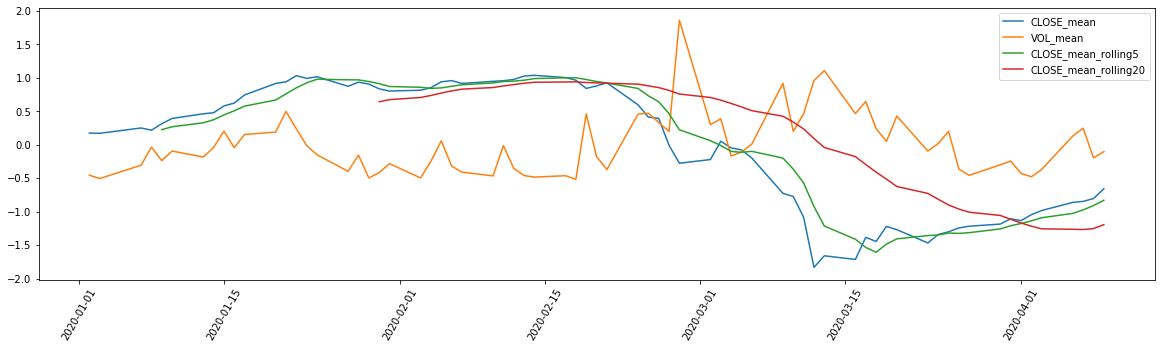

In [95]:
plt.figure(figsize=(20,5))
cols_to_plot = ['CLOSE_mean', 'VOL_mean',
                        'CLOSE_mean_rolling5',
                        'CLOSE_mean_rolling20']
plt.plot(df_stats.loc[:,cols_to_plot])
plt.xticks(rotation=60)
plt.legend(cols_to_plot)

## Model

In [12]:
### ADD WIG20 DAY BEFORE!

def transform_one_paper_ch(df):
    
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
        
    df.loc[:,'move_strength_abs'] =  abs(df.loc[:,'chng_CLOSE']) * abs(df.loc[:,'chng_VOL'])
    df.loc[:,'move_strength'] =  (df.loc[:,'chng_CLOSE']) * (df.loc[:,'chng_VOL'])
    
    
### COMPARISON SECTION
#are you on losing strike?
#str strike
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        for i in [5,10,20,30,60]:
            df.loc[:,f'comp{i}d_max' + col] = df.loc[:,col].rolling(i).max()
            df.loc[:,f'comp{i}d_max' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_max' + col]) - 100
            
            df.loc[:,f'comp{i}d_min' + col] = df.loc[:,col].rolling(i).min()
            df.loc[:,f'comp{i}d_min' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_min' + col]) - 100
            
            df.loc[:,f'comp{i}d_mean' + col] = df.loc[:,col].rolling(i).mean()
            df.loc[:,f'comp{i}d_mean' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_mean' + col]) - 100
            
            df.loc[:,f'comp{i}d_std' + col] = df.loc[:,col].rolling(i).std()
            df.loc[:,f'comp{i}d_std' + col] = (df.loc[:,col] * 100 / df.loc[:,f'comp{i}d_std' + col]) - 100
            
    
#     for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
#         cols = [f'comp{i}d_max' + col for i in [5,10,20]]
#         #df.loc[:,'all_higher_f'] = (df[cols] > 0).sum(axis = 1)
#         df.loc[:,'all_higher_cat'] = (df[cols] > 0).astype(str).sum(axis = 1)
        
#         cols = [f'comp{i}d_min' + col for i in [5,10,20]]
#         #df.loc[:,'all_lower_f'] = (df[cols] < 0).sum(axis = 1)
#         df.loc[:,'all_lower_cat'] = (df[cols] < 0).astype(str).sum(axis = 1)
    
            
### FUTURE SECTION ###

#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'fut_CLOSE_OPEN1'] = 0
    
    #df.loc[:, 'fut_OPEN_CLOSE_chng'] = (df.loc[:, 'OPEN'].shift(-1) * 100 / df.loc[:, 'CLOSE']) - 100
    
#     df.loc[:, 'chng_rel_OPEN'] = np.nan
#     df.loc[df.loc[:, 'HIGH'] > df.loc[:, 'OPEN'] * 1.01,'chng_rel_OPEN'] = 1
#     df.loc[df.loc[:, 'HIGH'] <= df.loc[:, 'OPEN'] * 1.01, 'chng_rel_OPEN'] = 0
    
#     df.loc[df.loc[:, 'OPEN'] < df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 1
#     df.loc[df.loc[:, 'OPEN'] >= df.loc[:, 'HIGH'],'comp_HIGH_OPEN'] = 0


### DIFFS SECTION ###
    df.loc[:,'diff_LOW_HIGH'] = (df.loc[:,'HIGH'] - df.loc[:,'LOW']) / df.loc[:,'HIGH']
    df.loc[:,'diff_OPEN_CLOSE'] = (df.loc[:,'OPEN'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_LOW_CLOSE'] = (df.loc[:,'CLOSE'] - df.loc[:,'LOW']) / df.loc[:,'CLOSE']
    df.loc[:,'diff_HIGH_CLOSE'] = (df.loc[:,'HIGH'] - df.loc[:,'CLOSE']) / df.loc[:,'CLOSE']
    
    
### HISTORIC SECTION ###

    for a in [c for c in df.columns if ('diff_' in c) | ('chng' in c) | ('chng_' in c)]:
        for i in [1, 2, 3]:
            df.loc[:,f'hist{i}_' + a] = df.loc[:,a].shift(i)

### GET SOME MEANS ###
#Trye min and maxes and some std?
    for b in [c for c in df.columns if (('chng_' in c) 
                                        | ('move_' in c) 
                                        | ('diff_' in c)
                                       | ('same_' in c)) & ('hist' not in c)]:
        for g in [2, 3, 5, 10, 20]:
            df.loc[:,f'roll{g}m_' + b] = df.loc[:,b].rolling(g).mean()
            df.loc[:,f'roll{g}min_' + b] = df.loc[:,b].rolling(g).min()
            df.loc[:,f'roll{g}max_' + b] = df.loc[:,b].rolling(g).max()
            df.loc[:,f'roll{g}std_' + b] = df.loc[:,b].rolling(g).std()


### SUBTARGET ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'subtarget'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'subtarget'] = 0
            
### TARGET SECTION ###
#pick one the of the available sections

## HIGHER HIGH ###
#     df.loc[df.loc[:, 'HIGH'].shift(-1) > df.loc[:, 'HIGH'],'target'] = 1
#     df.loc[df.loc[:, 'HIGH'].shift(-1) <= df.loc[:, 'HIGH'],'target'] = 0

### LOWER LOW ###
#     df.loc[df.loc[:, 'LOW'].shift(-1) < df.loc[:, 'LOW'],'target'] = 1
#     df.loc[df.loc[:, 'LOW'].shift(-1) >= df.loc[:, 'LOW'],'target'] = 0
    
### HIGHER OPENING ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1) > df.loc[:, 'CLOSE'],'target'] = 1
#     df.loc[df.loc[:, 'OPEN'].shift(-1) <= df.loc[:, 'CLOSE'],'target'] = 0
    
# ### HIGHER CLOSING THAN OPENING ###
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) > df.loc[:, 'OPEN'].shift(-1),'target'] = 1
#     df.loc[df.loc[:, 'CLOSE'].shift(-1) <= df.loc[:, 'OPEN'].shift(-1),'target'] = 0

### OPENING NOT FAR FROM LOW ###
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 > df.loc[:, 'LOW'].shift(-1),'target'] = 0
#     df.loc[df.loc[:, 'OPEN'].shift(-1)*0.995 <= df.loc[:, 'LOW'].shift(-1),'target'] = 1
    
### HIGH HIGHER MORE THAN 1% THAN OPENING ###
    df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 < df.loc[:, 'HIGH'].shift(-1),'target'] = 1
    df.loc[df.loc[:, 'OPEN'].shift(-1)*1.01 >=  df.loc[:, 'HIGH'].shift(-1),'target'] = 0
    
    return df

def transform_one_index(df):
    for col in ['OPEN', 'LOW', 'HIGH', 'CLOSE', 'VOL']:
        df.loc[:,col + '_shifted'] = df.loc[:,col].shift(1)
        df.loc[:,'chng_' + col] = np.nan
        df.loc[:,'chng_' + col] = (df.loc[:,col] * 100 / df.loc[:,col + '_shifted']) - 100
    return df

In [56]:
def f(q, res):
    while not (q.empty()):
        pap = q.get()
        df = prepare_data(pap)
        df = transform_one_paper_ch(df) 
        df = df.dropna()
        res.put(df)
    #print('done')
    
    
def put_res_together(resfin, res):
    
    while not (res.empty()):
        df_tofin = pd.DataFrame()
        #print(res.qsize())
        for i in range(10):
            try:
                df_one = res.get()
                df_tofin = pd.concat([df_tofin, df_one])
            except:
                resfin.put(df_tofin)
                break
        resfin.put(df_tofin)    
    #print('done')

In [57]:
q = Queue()
res = Queue()
resfin = Queue()

In [58]:
for w in (list(skaner_df_see.ticker.values) + watch):
    q.put(w)

In [59]:
%%time
p = Process(target=f, args=(q, res))
p2 = Process(target=f, args=(q, res))
p3 = Process(target=f, args=(q, res))
p4 = Process(target=f, args=(q, res))
p5 = Process(target=f, args=(q, res))
p.start()
p2.start()
p3.start()
p4.start()
p5.start()

total = q.qsize()
pbar = tqdm(total = total)

while(q.qsize()):
    if total > q.qsize():
        pbar.update(1)
        total = q.qsize()
pbar.close()

100%|██████████| 258/258 [01:16<00:00,  3.35it/s]

CPU times: user 1min 13s, sys: 558 ms, total: 1min 14s
Wall time: 1min 17s


In [60]:
pt = Process(target=put_res_together, args=(resfin, res))
pt2 = Process(target=put_res_together, args=(resfin, res))
pt3 = Process(target=put_res_together, args=(resfin, res))
pt4 = Process(target=put_res_together, args=(resfin, res))
pt.start()
pt2.start()
pt3.start()
pt4.start()

total = res.qsize()
pbar = tqdm(total = total)

while(res.qsize()):
    if total > res.qsize():
        pbar.update(1)
        total = res.qsize()
pbar.close()

100%|██████████| 257/257 [00:05<00:00, 47.34it/s]


In [61]:
%%time
df_merged = pd.DataFrame()

total = resfin.qsize()
pbar = tqdm(total = total)

while not resfin.empty():
    df = resfin.get()
    df_merged = pd.concat([df_merged, df])
    pbar.update(1)
pbar.close()

100%|██████████| 25/25 [00:22<00:00,  1.11it/s]

CPU times: user 7.78 s, sys: 14.4 s, total: 22.2 s
Wall time: 22.6 s


In [62]:
p.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
p5.terminate()

pt.terminate()
pt2.terminate()
pt3.terminate()
pt4.terminate()


gc.collect()

In [66]:
df_indexes_merged = pd.DataFrame()

for p in tqdm(all_indekses):
    
    df = prepare_index(p)
        
    df = transform_one_index(df) 
    #df = df.dropna()
    
    df_indexes_merged = pd.concat([df_indexes_merged, df])
    del df

100%|██████████| 23/23 [00:00<00:00, 34.74it/s]


In [67]:
df_indexes_merged = df_indexes_merged.pivot_table(index='DTYYYYMMDD', columns='TICKER', values='chng_CLOSE')
df_indexes_merged = df_indexes_merged.agg(['mean', 'max', 'min', 'std'], axis = 1)
df_indexes_merged = df_indexes_merged.add_prefix('foreign_stocks_')

df_merged = df_merged.merge(df_indexes_merged, left_index=True, right_index=True, how = 'left')

In [68]:
train_cols = [c for c in df_merged.columns if ('chng' in c) | ('move' in c) 
              | ('comp' in c) | ('fut' in c) | ('diff' in c) | ('same' in c) | ('hist' in c)]

train_cols = train_cols + list(df_indexes_merged.columns)

#train_cols = ['all_lower_cat', 'all_higher_cat'] + train_cols

In [69]:
#train_cols = train_cols_limited

df = df_merged.copy()
#df = df.loc[df.index > '2007-01-01',:]

In [70]:
cut_date = '2020-03-13'
train_data = df.loc[df.index < cut_date,train_cols]
eval_data = df.loc[df.index >= cut_date,train_cols]
train_labels = df.loc[df.index < cut_date,'target'].values
eval_labels = df.loc[df.index >= cut_date,'target'].values

In [71]:
def get_model():
    # Initialize CatBoostClassifier
    model = CatBoostClassifier(iterations=10000,
                           learning_rate=0.05,
                           depth=3,
                          thread_count=4,
                          eval_metric='AUC',
                          task_type='GPU')
    return model

In [72]:
model = get_model()

In [73]:
model.fit(train_data, train_labels, #cat_features=[0, 1],
          eval_set=[(eval_data[:-1], eval_labels[:-1])],
         early_stopping_rounds=500, use_best_model=True)

0:	learn: 0.6678731	test: 0.6112247	best: 0.6112247 (0)	total: 31.4ms	remaining: 5m 14s
1:	learn: 0.6778863	test: 0.6201804	best: 0.6201804 (1)	total: 47.5ms	remaining: 3m 57s
2:	learn: 0.6842023	test: 0.6320523	best: 0.6320523 (2)	total: 62.9ms	remaining: 3m 29s
3:	learn: 0.6856382	test: 0.6316601	best: 0.6320523 (2)	total: 79ms	remaining: 3m 17s
4:	learn: 0.6864128	test: 0.6323624	best: 0.6323624 (4)	total: 94.9ms	remaining: 3m 9s
5:	learn: 0.6891127	test: 0.6416428	best: 0.6416428 (5)	total: 111ms	remaining: 3m 4s
6:	learn: 0.6897472	test: 0.6471129	best: 0.6471129 (6)	total: 126ms	remaining: 3m
7:	learn: 0.6906685	test: 0.6468161	best: 0.6471129 (6)	total: 142ms	remaining: 2m 57s
8:	learn: 0.6916423	test: 0.6479972	best: 0.6479972 (8)	total: 157ms	remaining: 2m 54s
9:	learn: 0.6921624	test: 0.6486714	best: 0.6486714 (9)	total: 173ms	remaining: 2m 52s
10:	learn: 0.6928153	test: 0.6511941	best: 0.6511941 (10)	total: 188ms	remaining: 2m 50s
11:	learn: 0.6933726	test: 0.6515082	best: 0

104:	learn: 0.7078567	test: 0.6714376	best: 0.6714376 (104)	total: 1.49s	remaining: 2m 20s
105:	learn: 0.7079244	test: 0.6714474	best: 0.6714474 (105)	total: 1.5s	remaining: 2m 20s
106:	learn: 0.7079659	test: 0.6715023	best: 0.6715023 (106)	total: 1.52s	remaining: 2m 20s
107:	learn: 0.7080252	test: 0.6716088	best: 0.6716088 (107)	total: 1.53s	remaining: 2m 20s
108:	learn: 0.7080675	test: 0.6716324	best: 0.6716324 (108)	total: 1.54s	remaining: 2m 19s
109:	learn: 0.7081122	test: 0.6715228	best: 0.6716324 (108)	total: 1.56s	remaining: 2m 19s
110:	learn: 0.7081494	test: 0.6714937	best: 0.6716324 (108)	total: 1.57s	remaining: 2m 19s
111:	learn: 0.7082130	test: 0.6714924	best: 0.6716324 (108)	total: 1.58s	remaining: 2m 19s
112:	learn: 0.7082669	test: 0.6713408	best: 0.6716324 (108)	total: 1.59s	remaining: 2m 19s
113:	learn: 0.7082809	test: 0.6714069	best: 0.6716324 (108)	total: 1.61s	remaining: 2m 19s
114:	learn: 0.7083393	test: 0.6712855	best: 0.6716324 (108)	total: 1.62s	remaining: 2m 19s


196:	learn: 0.7108840	test: 0.6722996	best: 0.6723037 (193)	total: 2.71s	remaining: 2m 14s
197:	learn: 0.7109118	test: 0.6723154	best: 0.6723154 (197)	total: 2.72s	remaining: 2m 14s
198:	learn: 0.7109530	test: 0.6722846	best: 0.6723154 (197)	total: 2.74s	remaining: 2m 14s
199:	learn: 0.7109794	test: 0.6723832	best: 0.6723832 (199)	total: 2.75s	remaining: 2m 14s
200:	learn: 0.7110232	test: 0.6722718	best: 0.6723832 (199)	total: 2.76s	remaining: 2m 14s
201:	learn: 0.7110515	test: 0.6722822	best: 0.6723832 (199)	total: 2.78s	remaining: 2m 14s
202:	learn: 0.7110799	test: 0.6721551	best: 0.6723832 (199)	total: 2.79s	remaining: 2m 14s
203:	learn: 0.7111027	test: 0.6722165	best: 0.6723832 (199)	total: 2.81s	remaining: 2m 14s
204:	learn: 0.7111417	test: 0.6723247	best: 0.6723832 (199)	total: 2.82s	remaining: 2m 14s
205:	learn: 0.7111618	test: 0.6723004	best: 0.6723832 (199)	total: 2.83s	remaining: 2m 14s
206:	learn: 0.7111751	test: 0.6723242	best: 0.6723832 (199)	total: 2.85s	remaining: 2m 14s

288:	learn: 0.7128421	test: 0.6736887	best: 0.6736887 (288)	total: 3.95s	remaining: 2m 12s
289:	learn: 0.7128519	test: 0.6735494	best: 0.6736887 (288)	total: 3.96s	remaining: 2m 12s
290:	learn: 0.7128751	test: 0.6735641	best: 0.6736887 (288)	total: 3.98s	remaining: 2m 12s
291:	learn: 0.7128908	test: 0.6735530	best: 0.6736887 (288)	total: 4s	remaining: 2m 12s
292:	learn: 0.7129016	test: 0.6734757	best: 0.6736887 (288)	total: 4.01s	remaining: 2m 13s
293:	learn: 0.7129291	test: 0.6735516	best: 0.6736887 (288)	total: 4.03s	remaining: 2m 13s
294:	learn: 0.7129441	test: 0.6734530	best: 0.6736887 (288)	total: 4.05s	remaining: 2m 13s
295:	learn: 0.7129619	test: 0.6735018	best: 0.6736887 (288)	total: 4.07s	remaining: 2m 13s
296:	learn: 0.7129779	test: 0.6734971	best: 0.6736887 (288)	total: 4.08s	remaining: 2m 13s
297:	learn: 0.7129952	test: 0.6734954	best: 0.6736887 (288)	total: 4.1s	remaining: 2m 13s
298:	learn: 0.7130077	test: 0.6734891	best: 0.6736887 (288)	total: 4.12s	remaining: 2m 13s
299

384:	learn: 0.7142601	test: 0.6747202	best: 0.6748098 (378)	total: 5.41s	remaining: 2m 15s
385:	learn: 0.7142705	test: 0.6747670	best: 0.6748098 (378)	total: 5.42s	remaining: 2m 15s
386:	learn: 0.7142878	test: 0.6747996	best: 0.6748098 (378)	total: 5.44s	remaining: 2m 15s
387:	learn: 0.7143062	test: 0.6748092	best: 0.6748098 (378)	total: 5.45s	remaining: 2m 14s
388:	learn: 0.7143126	test: 0.6749266	best: 0.6749266 (388)	total: 5.46s	remaining: 2m 14s
389:	learn: 0.7143201	test: 0.6749188	best: 0.6749266 (388)	total: 5.47s	remaining: 2m 14s
390:	learn: 0.7143322	test: 0.6748735	best: 0.6749266 (388)	total: 5.49s	remaining: 2m 14s
391:	learn: 0.7143409	test: 0.6749078	best: 0.6749266 (388)	total: 5.5s	remaining: 2m 14s
392:	learn: 0.7143504	test: 0.6749428	best: 0.6749428 (392)	total: 5.52s	remaining: 2m 14s
393:	learn: 0.7143617	test: 0.6749741	best: 0.6749741 (393)	total: 5.53s	remaining: 2m 14s
394:	learn: 0.7143823	test: 0.6749917	best: 0.6749917 (394)	total: 5.54s	remaining: 2m 14s


490:	learn: 0.7154749	test: 0.6758925	best: 0.6760209 (442)	total: 6.84s	remaining: 2m 12s
491:	learn: 0.7154825	test: 0.6759159	best: 0.6760209 (442)	total: 6.85s	remaining: 2m 12s
492:	learn: 0.7154891	test: 0.6759028	best: 0.6760209 (442)	total: 6.87s	remaining: 2m 12s
493:	learn: 0.7154955	test: 0.6759154	best: 0.6760209 (442)	total: 6.88s	remaining: 2m 12s
494:	learn: 0.7155027	test: 0.6759412	best: 0.6760209 (442)	total: 6.89s	remaining: 2m 12s
495:	learn: 0.7155153	test: 0.6759601	best: 0.6760209 (442)	total: 6.91s	remaining: 2m 12s
496:	learn: 0.7155254	test: 0.6759601	best: 0.6760209 (442)	total: 6.92s	remaining: 2m 12s
497:	learn: 0.7155398	test: 0.6759694	best: 0.6760209 (442)	total: 6.93s	remaining: 2m 12s
498:	learn: 0.7155526	test: 0.6759374	best: 0.6760209 (442)	total: 6.95s	remaining: 2m 12s
499:	learn: 0.7155602	test: 0.6760899	best: 0.6760899 (499)	total: 6.96s	remaining: 2m 12s
500:	learn: 0.7155692	test: 0.6761204	best: 0.6761204 (500)	total: 6.98s	remaining: 2m 12s

588:	learn: 0.7163396	test: 0.6765896	best: 0.6767284 (579)	total: 8.28s	remaining: 2m 12s
589:	learn: 0.7163494	test: 0.6765711	best: 0.6767284 (579)	total: 8.29s	remaining: 2m 12s
590:	learn: 0.7163612	test: 0.6765952	best: 0.6767284 (579)	total: 8.3s	remaining: 2m 12s
591:	learn: 0.7163712	test: 0.6765769	best: 0.6767284 (579)	total: 8.32s	remaining: 2m 12s
592:	learn: 0.7163791	test: 0.6765710	best: 0.6767284 (579)	total: 8.33s	remaining: 2m 12s
593:	learn: 0.7163903	test: 0.6765659	best: 0.6767284 (579)	total: 8.35s	remaining: 2m 12s
594:	learn: 0.7163988	test: 0.6765664	best: 0.6767284 (579)	total: 8.36s	remaining: 2m 12s
595:	learn: 0.7164066	test: 0.6765168	best: 0.6767284 (579)	total: 8.37s	remaining: 2m 12s
596:	learn: 0.7164140	test: 0.6764946	best: 0.6767284 (579)	total: 8.38s	remaining: 2m 12s
597:	learn: 0.7164258	test: 0.6765078	best: 0.6767284 (579)	total: 8.4s	remaining: 2m 12s
598:	learn: 0.7164318	test: 0.6764580	best: 0.6767284 (579)	total: 8.41s	remaining: 2m 12s
5

680:	learn: 0.7170772	test: 0.6761552	best: 0.6767284 (579)	total: 9.51s	remaining: 2m 10s
681:	learn: 0.7170796	test: 0.6761301	best: 0.6767284 (579)	total: 9.53s	remaining: 2m 10s
682:	learn: 0.7170823	test: 0.6761483	best: 0.6767284 (579)	total: 9.54s	remaining: 2m 10s
683:	learn: 0.7170948	test: 0.6761510	best: 0.6767284 (579)	total: 9.55s	remaining: 2m 10s
684:	learn: 0.7171036	test: 0.6761491	best: 0.6767284 (579)	total: 9.57s	remaining: 2m 10s
685:	learn: 0.7171119	test: 0.6761507	best: 0.6767284 (579)	total: 9.58s	remaining: 2m 10s
686:	learn: 0.7171195	test: 0.6761757	best: 0.6767284 (579)	total: 9.59s	remaining: 2m 10s
687:	learn: 0.7171262	test: 0.6762201	best: 0.6767284 (579)	total: 9.61s	remaining: 2m 10s
688:	learn: 0.7171327	test: 0.6762064	best: 0.6767284 (579)	total: 9.62s	remaining: 2m 9s
689:	learn: 0.7171441	test: 0.6761955	best: 0.6767284 (579)	total: 9.63s	remaining: 2m 9s
690:	learn: 0.7171490	test: 0.6761767	best: 0.6767284 (579)	total: 9.65s	remaining: 2m 9s
69

781:	learn: 0.7178087	test: 0.6762468	best: 0.6767284 (579)	total: 10.9s	remaining: 2m 9s
782:	learn: 0.7178133	test: 0.6762683	best: 0.6767284 (579)	total: 11s	remaining: 2m 9s
783:	learn: 0.7178159	test: 0.6762987	best: 0.6767284 (579)	total: 11s	remaining: 2m 9s
784:	learn: 0.7178214	test: 0.6763043	best: 0.6767284 (579)	total: 11s	remaining: 2m 9s
785:	learn: 0.7178271	test: 0.6762807	best: 0.6767284 (579)	total: 11s	remaining: 2m 9s
786:	learn: 0.7178332	test: 0.6763306	best: 0.6767284 (579)	total: 11s	remaining: 2m 9s
787:	learn: 0.7178444	test: 0.6762843	best: 0.6767284 (579)	total: 11s	remaining: 2m 9s
788:	learn: 0.7178492	test: 0.6763219	best: 0.6767284 (579)	total: 11.1s	remaining: 2m 9s
789:	learn: 0.7178566	test: 0.6763399	best: 0.6767284 (579)	total: 11.1s	remaining: 2m 9s
790:	learn: 0.7178627	test: 0.6763983	best: 0.6767284 (579)	total: 11.1s	remaining: 2m 9s
791:	learn: 0.7178684	test: 0.6763660	best: 0.6767284 (579)	total: 11.1s	remaining: 2m 9s
792:	learn: 0.7178707	

880:	learn: 0.7184190	test: 0.6771366	best: 0.6771366 (880)	total: 12.4s	remaining: 2m 8s
881:	learn: 0.7184242	test: 0.6771379	best: 0.6771379 (881)	total: 12.4s	remaining: 2m 8s
882:	learn: 0.7184273	test: 0.6770965	best: 0.6771379 (881)	total: 12.4s	remaining: 2m 8s
883:	learn: 0.7184300	test: 0.6771479	best: 0.6771479 (883)	total: 12.4s	remaining: 2m 7s
884:	learn: 0.7184394	test: 0.6771454	best: 0.6771479 (883)	total: 12.4s	remaining: 2m 7s
885:	learn: 0.7184454	test: 0.6771080	best: 0.6771479 (883)	total: 12.4s	remaining: 2m 7s
886:	learn: 0.7184515	test: 0.6771006	best: 0.6771479 (883)	total: 12.5s	remaining: 2m 7s
887:	learn: 0.7184553	test: 0.6771138	best: 0.6771479 (883)	total: 12.5s	remaining: 2m 7s
888:	learn: 0.7184577	test: 0.6771231	best: 0.6771479 (883)	total: 12.5s	remaining: 2m 7s
889:	learn: 0.7184618	test: 0.6771656	best: 0.6771656 (889)	total: 12.5s	remaining: 2m 7s
890:	learn: 0.7184674	test: 0.6771401	best: 0.6771656 (889)	total: 12.5s	remaining: 2m 7s
891:	learn

973:	learn: 0.7189075	test: 0.6771036	best: 0.6773335 (900)	total: 13.6s	remaining: 2m 6s
974:	learn: 0.7189108	test: 0.6771113	best: 0.6773335 (900)	total: 13.6s	remaining: 2m 6s
975:	learn: 0.7189186	test: 0.6770747	best: 0.6773335 (900)	total: 13.6s	remaining: 2m 6s
976:	learn: 0.7189273	test: 0.6774259	best: 0.6774259 (976)	total: 13.6s	remaining: 2m 6s
977:	learn: 0.7189304	test: 0.6774429	best: 0.6774429 (977)	total: 13.7s	remaining: 2m 6s
978:	learn: 0.7189328	test: 0.6774641	best: 0.6774641 (978)	total: 13.7s	remaining: 2m 6s
979:	learn: 0.7189353	test: 0.6774753	best: 0.6774753 (979)	total: 13.7s	remaining: 2m 6s
980:	learn: 0.7189426	test: 0.6774687	best: 0.6774753 (979)	total: 13.7s	remaining: 2m 5s
981:	learn: 0.7189468	test: 0.6774181	best: 0.6774753 (979)	total: 13.7s	remaining: 2m 5s
982:	learn: 0.7189520	test: 0.6774206	best: 0.6774753 (979)	total: 13.7s	remaining: 2m 5s
983:	learn: 0.7189572	test: 0.6774116	best: 0.6774753 (979)	total: 13.7s	remaining: 2m 5s
984:	learn

1064:	learn: 0.7193528	test: 0.6774470	best: 0.6776908 (1035)	total: 14.8s	remaining: 2m 4s
1065:	learn: 0.7193598	test: 0.6773750	best: 0.6776908 (1035)	total: 14.8s	remaining: 2m 4s
1066:	learn: 0.7193658	test: 0.6773796	best: 0.6776908 (1035)	total: 14.8s	remaining: 2m 4s
1067:	learn: 0.7193680	test: 0.6773755	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1068:	learn: 0.7193722	test: 0.6773758	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1069:	learn: 0.7193755	test: 0.6773431	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1070:	learn: 0.7193825	test: 0.6773451	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1071:	learn: 0.7193876	test: 0.6773509	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1072:	learn: 0.7193949	test: 0.6773205	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1073:	learn: 0.7194025	test: 0.6773252	best: 0.6776908 (1035)	total: 14.9s	remaining: 2m 4s
1074:	learn: 0.7194067	test: 0.6773220	best: 0.6776908 (1035)	total: 15s	remaini

1154:	learn: 0.7197677	test: 0.6772226	best: 0.6776908 (1035)	total: 16.1s	remaining: 2m 3s
1155:	learn: 0.7197716	test: 0.6772175	best: 0.6776908 (1035)	total: 16.1s	remaining: 2m 3s
1156:	learn: 0.7197756	test: 0.6772108	best: 0.6776908 (1035)	total: 16.1s	remaining: 2m 3s
1157:	learn: 0.7197834	test: 0.6771560	best: 0.6776908 (1035)	total: 16.1s	remaining: 2m 3s
1158:	learn: 0.7197889	test: 0.6771633	best: 0.6776908 (1035)	total: 16.1s	remaining: 2m 3s
1159:	learn: 0.7197920	test: 0.6772329	best: 0.6776908 (1035)	total: 16.1s	remaining: 2m 3s
1160:	learn: 0.7197937	test: 0.6772082	best: 0.6776908 (1035)	total: 16.2s	remaining: 2m 3s
1161:	learn: 0.7197959	test: 0.6772048	best: 0.6776908 (1035)	total: 16.2s	remaining: 2m 3s
1162:	learn: 0.7198007	test: 0.6772128	best: 0.6776908 (1035)	total: 16.2s	remaining: 2m 2s
1163:	learn: 0.7198029	test: 0.6772169	best: 0.6776908 (1035)	total: 16.2s	remaining: 2m 2s
1164:	learn: 0.7198060	test: 0.6772232	best: 0.6776908 (1035)	total: 16.2s	remai

1248:	learn: 0.7201980	test: 0.6773261	best: 0.6776908 (1035)	total: 17.5s	remaining: 2m 2s
1249:	learn: 0.7202017	test: 0.6773608	best: 0.6776908 (1035)	total: 17.5s	remaining: 2m 2s
1250:	learn: 0.7202052	test: 0.6773912	best: 0.6776908 (1035)	total: 17.5s	remaining: 2m 2s
1251:	learn: 0.7202103	test: 0.6773866	best: 0.6776908 (1035)	total: 17.5s	remaining: 2m 2s
1252:	learn: 0.7202116	test: 0.6773903	best: 0.6776908 (1035)	total: 17.6s	remaining: 2m 2s
1253:	learn: 0.7202139	test: 0.6773954	best: 0.6776908 (1035)	total: 17.6s	remaining: 2m 2s
1254:	learn: 0.7202184	test: 0.6773562	best: 0.6776908 (1035)	total: 17.6s	remaining: 2m 2s
1255:	learn: 0.7202220	test: 0.6772727	best: 0.6776908 (1035)	total: 17.6s	remaining: 2m 2s
1256:	learn: 0.7202245	test: 0.6772459	best: 0.6776908 (1035)	total: 17.6s	remaining: 2m 2s
1257:	learn: 0.7202328	test: 0.6772727	best: 0.6776908 (1035)	total: 17.6s	remaining: 2m 2s
1258:	learn: 0.7202364	test: 0.6772633	best: 0.6776908 (1035)	total: 17.6s	remai

1345:	learn: 0.7205847	test: 0.6778248	best: 0.6778983 (1322)	total: 18.9s	remaining: 2m 1s
1346:	learn: 0.7205878	test: 0.6778163	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1347:	learn: 0.7205909	test: 0.6778187	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1348:	learn: 0.7205939	test: 0.6778733	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1349:	learn: 0.7205981	test: 0.6778517	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1350:	learn: 0.7206018	test: 0.6778683	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1351:	learn: 0.7206069	test: 0.6778750	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1352:	learn: 0.7206118	test: 0.6778817	best: 0.6778983 (1322)	total: 19s	remaining: 2m 1s
1353:	learn: 0.7206147	test: 0.6778581	best: 0.6778983 (1322)	total: 19.1s	remaining: 2m 1s
1354:	learn: 0.7206178	test: 0.6778815	best: 0.6778983 (1322)	total: 19.1s	remaining: 2m 1s
1355:	learn: 0.7206213	test: 0.6778830	best: 0.6778983 (1322)	total: 19.1s	remaining: 2m 1s
13

1437:	learn: 0.7209383	test: 0.6778390	best: 0.6779747 (1391)	total: 20.2s	remaining: 2m
1438:	learn: 0.7209418	test: 0.6778441	best: 0.6779747 (1391)	total: 20.2s	remaining: 2m
1439:	learn: 0.7209467	test: 0.6778140	best: 0.6779747 (1391)	total: 20.2s	remaining: 2m
1440:	learn: 0.7209502	test: 0.6778153	best: 0.6779747 (1391)	total: 20.2s	remaining: 2m
1441:	learn: 0.7209556	test: 0.6778215	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1442:	learn: 0.7209584	test: 0.6778127	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1443:	learn: 0.7209643	test: 0.6778335	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1444:	learn: 0.7209725	test: 0.6778303	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1445:	learn: 0.7209773	test: 0.6778321	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1446:	learn: 0.7209789	test: 0.6778399	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1447:	learn: 0.7209806	test: 0.6778757	best: 0.6779747 (1391)	total: 20.3s	remaining: 2m
1448:	learn: 0.720985

1531:	learn: 0.7212934	test: 0.6777710	best: 0.6780609 (1484)	total: 21.6s	remaining: 1m 59s
1532:	learn: 0.7212983	test: 0.6777326	best: 0.6780609 (1484)	total: 21.6s	remaining: 1m 59s
1533:	learn: 0.7213010	test: 0.6776992	best: 0.6780609 (1484)	total: 21.6s	remaining: 1m 59s
1534:	learn: 0.7213051	test: 0.6777192	best: 0.6780609 (1484)	total: 21.7s	remaining: 1m 59s
1535:	learn: 0.7213080	test: 0.6777152	best: 0.6780609 (1484)	total: 21.7s	remaining: 1m 59s
1536:	learn: 0.7213122	test: 0.6777110	best: 0.6780609 (1484)	total: 21.7s	remaining: 1m 59s
1537:	learn: 0.7213134	test: 0.6776762	best: 0.6780609 (1484)	total: 21.7s	remaining: 1m 59s
1538:	learn: 0.7213150	test: 0.6776731	best: 0.6780609 (1484)	total: 21.7s	remaining: 1m 59s
1539:	learn: 0.7213182	test: 0.6777313	best: 0.6780609 (1484)	total: 21.7s	remaining: 1m 59s
1540:	learn: 0.7213228	test: 0.6777176	best: 0.6780609 (1484)	total: 21.8s	remaining: 1m 59s
1541:	learn: 0.7213243	test: 0.6776882	best: 0.6780609 (1484)	total: 2

1626:	learn: 0.7216373	test: 0.6770360	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1627:	learn: 0.7216410	test: 0.6770478	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1628:	learn: 0.7216468	test: 0.6770546	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1629:	learn: 0.7216498	test: 0.6770917	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1630:	learn: 0.7216522	test: 0.6770864	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1631:	learn: 0.7216538	test: 0.6771377	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1632:	learn: 0.7216575	test: 0.6772330	best: 0.6780609 (1484)	total: 23.1s	remaining: 1m 58s
1633:	learn: 0.7216592	test: 0.6772385	best: 0.6780609 (1484)	total: 23.2s	remaining: 1m 58s
1634:	learn: 0.7216614	test: 0.6771843	best: 0.6780609 (1484)	total: 23.2s	remaining: 1m 58s
1635:	learn: 0.7216647	test: 0.6771457	best: 0.6780609 (1484)	total: 23.2s	remaining: 1m 58s
1636:	learn: 0.7216700	test: 0.6771142	best: 0.6780609 (1484)	total: 2

1724:	learn: 0.7219909	test: 0.6771518	best: 0.6780609 (1484)	total: 24.5s	remaining: 1m 57s
1725:	learn: 0.7219933	test: 0.6771528	best: 0.6780609 (1484)	total: 24.5s	remaining: 1m 57s
1726:	learn: 0.7219988	test: 0.6771578	best: 0.6780609 (1484)	total: 24.5s	remaining: 1m 57s
1727:	learn: 0.7220011	test: 0.6771639	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1728:	learn: 0.7220038	test: 0.6771606	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1729:	learn: 0.7220066	test: 0.6771754	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1730:	learn: 0.7220088	test: 0.6771831	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1731:	learn: 0.7220136	test: 0.6771618	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1732:	learn: 0.7220174	test: 0.6771130	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1733:	learn: 0.7220213	test: 0.6770958	best: 0.6780609 (1484)	total: 24.6s	remaining: 1m 57s
1734:	learn: 0.7220247	test: 0.6770990	best: 0.6780609 (1484)	total: 2

1815:	learn: 0.7222932	test: 0.6774933	best: 0.6780609 (1484)	total: 25.7s	remaining: 1m 55s
1816:	learn: 0.7222961	test: 0.6774933	best: 0.6780609 (1484)	total: 25.8s	remaining: 1m 55s
1817:	learn: 0.7223002	test: 0.6774967	best: 0.6780609 (1484)	total: 25.8s	remaining: 1m 55s
1818:	learn: 0.7223035	test: 0.6774982	best: 0.6780609 (1484)	total: 25.8s	remaining: 1m 55s
1819:	learn: 0.7223078	test: 0.6775076	best: 0.6780609 (1484)	total: 25.8s	remaining: 1m 55s
1820:	learn: 0.7223145	test: 0.6774886	best: 0.6780609 (1484)	total: 25.8s	remaining: 1m 55s
1821:	learn: 0.7223191	test: 0.6774819	best: 0.6780609 (1484)	total: 25.8s	remaining: 1m 55s
1822:	learn: 0.7223202	test: 0.6774832	best: 0.6780609 (1484)	total: 25.9s	remaining: 1m 55s
1823:	learn: 0.7223268	test: 0.6774725	best: 0.6780609 (1484)	total: 25.9s	remaining: 1m 55s
1824:	learn: 0.7223296	test: 0.6774639	best: 0.6780609 (1484)	total: 25.9s	remaining: 1m 55s
1825:	learn: 0.7223336	test: 0.6774405	best: 0.6780609 (1484)	total: 2

1912:	learn: 0.7226145	test: 0.6774668	best: 0.6780609 (1484)	total: 27.2s	remaining: 1m 54s
1913:	learn: 0.7226185	test: 0.6774789	best: 0.6780609 (1484)	total: 27.2s	remaining: 1m 54s
1914:	learn: 0.7226222	test: 0.6774701	best: 0.6780609 (1484)	total: 27.2s	remaining: 1m 54s
1915:	learn: 0.7226250	test: 0.6774545	best: 0.6780609 (1484)	total: 27.2s	remaining: 1m 54s
1916:	learn: 0.7226270	test: 0.6774193	best: 0.6780609 (1484)	total: 27.2s	remaining: 1m 54s
1917:	learn: 0.7226315	test: 0.6774178	best: 0.6780609 (1484)	total: 27.2s	remaining: 1m 54s
1918:	learn: 0.7226352	test: 0.6774372	best: 0.6780609 (1484)	total: 27.3s	remaining: 1m 54s
1919:	learn: 0.7226405	test: 0.6774272	best: 0.6780609 (1484)	total: 27.3s	remaining: 1m 54s
1920:	learn: 0.7226465	test: 0.6774242	best: 0.6780609 (1484)	total: 27.3s	remaining: 1m 54s
1921:	learn: 0.7226525	test: 0.6773385	best: 0.6780609 (1484)	total: 27.3s	remaining: 1m 54s
1922:	learn: 0.7226539	test: 0.6773525	best: 0.6780609 (1484)	total: 2

In [74]:
model.get_feature_importance(prettified=True).head(10)

,Feature Id,Importances
0,roll20std_diff_LOW_HIGH,11.104205
1,roll20m_diff_LOW_HIGH,7.183462
2,diff_LOW_HIGH,5.089124
3,roll20min_diff_OPEN_CLOSE,4.197762
4,roll20m_diff_OPEN_CLOSE,4.011631
5,roll10m_diff_LOW_HIGH,3.403720
6,roll10min_diff_OPEN_CLOSE,3.124898
7,roll20m_diff_LOW_CLOSE,3.066215
8,roll3m_diff_LOW_HIGH,3.014723
9,roll20min_diff_LOW_HIGH,2.997230


In [75]:
working_feats_785_on_high = ['diff_HIGH_CLOSE', 'diff_OPEN_CLOSE','roll20min_diff_LOW_HIGH',
                     'chng_HIGH','roll2std_chng_HIGH',
                     'comp5d_stdHIGH','roll20min_chng_VOL','comp5d_meanOPEN','move_strength_abs',
                     'roll2min_chng_HIGH','roll3min_move_strength_abs']

imp = model.get_feature_importance(prettified=True)
train_cols_limited  = [c for c in train_cols if c in imp.loc[imp.Importances >= 0.01, 'Feature Id'].values]
#train_cols_limited = working_feats_785_on_high
len(train_cols) - len(train_cols_limited)

101

#### Analysis categorical

In [76]:
preds_class = model.predict(eval_data)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(eval_data)
# Get predicted RawFormulaVal
preds_raw = model.predict(eval_data, prediction_type='RawFormulaVal')

# pred_class = pd.Series()

# for m in models:
#     if not pred_class.shape[0]:
#         pred_class = m.predict(eval_data)
#     else:
#         pred_class = pred_class + m.predict(eval_data)

# pred_class = pred_class / 4

preds = preds_class[:-1].astype(int)

In [110]:
# preds_proba = pd.Series()

# for m in models:
#     if not pred_class.shape[0]:
#         preds_proba = m.predict_proba(eval_data)[:,1]
#     else:
#         preds_proba = pred_class + m.predict_proba(eval_data)[:,1]

# preds_proba = preds_proba / 4

# preds_proba = preds_proba[:,1]

preds = preds_proba

preds[preds > 0.51] = 1
preds[preds < 1] = 0
preds = preds[:-1].astype(int)

In [77]:
confusion_matrix(eval_labels[:-1].astype(int), preds)

array([[1125, 1248],
       [ 675, 2288]])

In [78]:
tn, fp, fn, tp = confusion_matrix(eval_labels[:-1].astype(int), preds).ravel()
(tn, fp, fn, tp)

(1125, 1248, 675, 2288)

In [79]:
(tn + tp) / (tn + tp + fp + fn)

0.6396176911544228

In [80]:
tp / (tp + fp)

0.6470588235294118

In [81]:
df_res = pd.concat([pd.DataFrame(preds_proba), pd.Series(eval_labels)], axis=1)
df_res.columns = ['zero', 'one', 'true']
df_res.groupby('true').mean()

,zero,one
true,,
0.0,0.509234,0.490766
1.0,0.409845,0.590155


In [82]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(1)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(1)
df_res_grouped = df_res.drop('zero', axis = 1)

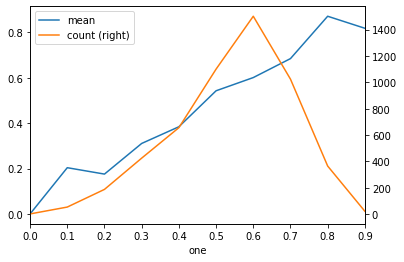

In [83]:
# df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3
# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.55
df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])
df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)
df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

In [84]:
df_res_grouped

,mean,count
one,,
0.0,0.000000,2
0.1,0.203704,54
0.2,0.175532,188
0.3,0.310588,425
0.4,0.384146,656
0.5,0.542727,1100
0.6,0.600933,1501
0.7,0.684570,1024
0.8,0.871233,365


### Prediction

#### Categorical

In [85]:
eval_data.loc[:,'target'] = eval_labels
eval_data.loc[:,'target'] = eval_data.loc[:,'target']
eval_data.loc[:,'pred_class'] = model.predict(eval_data[train_cols])

eval_data.loc[:,'pred_proba'] = model.predict_proba(eval_data[train_cols])[:,1]
eval_data.loc[:,'pred_proba'] = eval_data.loc[:,'pred_proba'].round(1)

#### Prediction for couple of papers

In [86]:
res = pd.DataFrame()

In [87]:
df_merged.target.value_counts()

0.0    459688
1.0    269702
Name: target, dtype: int64

In [88]:
for p in tqdm(list(skaner_df_see.ticker.values) + watch):

    df = prepare_data(p)
    df = transform_one_paper_ch(df)

    df = df.merge(df_indexes_merged,
                  left_index=True,
                  right_index=True,
                  how='left')

    df.loc[:, 'pred_class'] = model.predict(df[train_cols])
    df.loc[:, 'pred_prob'] = model.predict_proba(df[train_cols])[:, 1]

    df.loc[:, 'fut_OPEN'] = df.loc[:, 'OPEN'].shift(-1)
    df.loc[:, 'fut_CLOSE'] = df.loc[:, 'CLOSE'].shift(-1)
    df.loc[:, 'target_gains'] = (df.loc[:, 'fut_CLOSE'] * 100 /
                                 df.loc[:, 'fut_OPEN']) - 100
    df.loc[:, 'target_OPEN_chng'] = (df.loc[:, 'fut_OPEN'] * 100 /
                                     df.loc[:, 'CLOSE']) - 100
    df.loc[:, 'target_HIGH_chng'] = df.loc[:, 'chng_HIGH'].shift(-1).copy()
    df.loc[:, 'target_CLOSE_chng'] = df.loc[:, 'chng_CLOSE'].shift(-1).copy()

    one_res = df.reset_index().loc[:, [
        'DTYYYYMMDD', 'TICKER', 'OPEN', 'LOW', 'HIGH', 'CLOSE', 'target',
        'pred_class', 'target_OPEN_chng', 'target_HIGH_chng',
        'target_CLOSE_chng', 'target_gains', 'pred_prob'
    ]].tail(15)
    res = pd.concat([res, one_res])

100%|██████████| 262/262 [03:45<00:00,  1.16it/s]


In [89]:
res_see = res.sort_values('pred_prob', ascending=False).copy()
res_see = res_see.drop_duplicates()
res_see.loc[res_see.pred_prob > 0.5].groupby('DTYYYYMMDD').mean().mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

target_OPEN_chng    -0.091508
target_HIGH_chng     0.768197
target_CLOSE_chng    0.876100
target_gains         1.012478
dtype: float64

In [90]:
res_see.loc[:,'pred_prob_rounded'] = res_see.pred_prob.round(1)

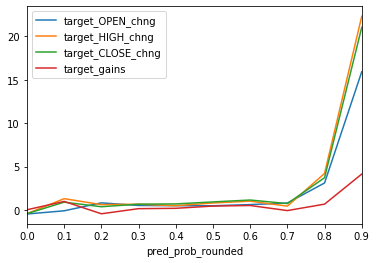

In [91]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']].plot()

In [92]:
res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains
pred_prob_rounded,,,,
0.0,-0.446972,-0.407312,-0.407612,0.039885
0.1,-0.076972,1.319469,0.919571,1.003529
0.2,0.838205,0.633869,0.390130,-0.419619
0.3,0.538278,0.681568,0.688898,0.167654
0.4,0.512742,0.512726,0.715148,0.210677
0.5,0.502619,0.822701,0.945658,0.466910
0.6,0.637796,1.035346,1.164796,0.533442
0.7,0.814900,0.457629,0.753751,-0.051574
0.8,3.126858,4.223931,3.732391,0.688425


In [133]:
res_see_agg = res_see.groupby('pred_prob_rounded').mean()[['target_OPEN_chng', 'target_HIGH_chng', 
                                             'target_CLOSE_chng', 'target_gains']]

In [135]:
res_see.loc[(res_see.pred_prob > 0) 
            & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')].sort_values('pred_prob', ascending=False).head(100)

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
841,2020-04-15,TBULL,14.1000,13.700,16.500,15.9000,1.0,1.0,0.628931,0.000000,2.830189,2.187500,0.861958,0.9
3179,2020-04-15,KOMPUTRON,1.2950,1.285,1.520,1.5100,1.0,1.0,5.298013,30.921053,31.125828,24.528302,0.823620,0.8
1057,2020-04-15,ENTER,25.0000,23.200,27.000,24.8000,0.0,1.0,4.032258,-4.444444,-4.032258,-7.751938,0.822492,0.8
3094,2020-04-15,RAINBOW,15.2000,14.000,16.400,14.9000,1.0,1.0,0.671141,-5.182927,-10.067114,-10.666667,0.820843,0.8
2040,2020-04-15,BIOMEDLUB,2.5800,2.410,3.800,3.8000,1.0,1.0,-10.789474,-2.105263,-11.052632,-0.294985,0.807443,0.8
5465,2020-04-15,TIM,9.5200,9.500,10.350,9.7200,1.0,1.0,0.000000,-0.483092,4.423868,4.423868,0.773835,0.8
1707,2020-04-15,UNIMOT,21.6000,20.700,22.600,22.0000,1.0,1.0,0.000000,2.212389,4.545455,4.545455,0.765069,0.8
3736,2020-04-15,AMREST,30.0000,26.100,31.250,28.7000,1.0,1.0,-0.348432,-7.360000,-8.536585,-8.216783,0.764013,0.8
3026,2020-04-15,ASBIS,3.4000,3.170,3.480,3.1700,1.0,1.0,0.946372,-4.310345,2.208202,1.250000,0.763845,0.8
6371,2020-04-15,MOSTALZAB,0.6580,0.600,0.674,0.6120,1.0,1.0,0.980392,-4.154303,3.267974,2.265372,0.761035,0.8


In [136]:
res_see.loc[(res_see.TICKER.apply(lambda x: True if x in watch else False) & (res_see.loc[:,'DTYYYYMMDD'] == '2020-04-15')),:]

,DTYYYYMMDD,TICKER,OPEN,LOW,HIGH,CLOSE,target,pred_class,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,target_gains,pred_prob,pred_prob_rounded
2040,2020-04-15,BIOMEDLUB,2.58,2.410,3.800,3.800,1.0,1.0,-10.789474,-2.105263,-11.052632,-0.294985,0.807443,0.8
3736,2020-04-15,AMREST,30.00,26.100,31.250,28.700,1.0,1.0,-0.348432,-7.360000,-8.536585,-8.216783,0.764013,0.8
2187,2020-04-15,JSW,15.00,13.610,15.185,13.810,0.0,1.0,0.289645,-8.495226,-1.375815,-1.660650,0.753465,0.8
1681,2020-04-15,SUNEX,9.90,9.000,9.980,9.280,1.0,1.0,-0.862069,-4.208417,2.801724,3.695652,0.746404,0.7
5694,2020-04-15,KGHM,76.00,69.520,76.000,70.260,0.0,1.0,1.053231,-5.973684,0.512383,-0.535211,0.727823,0.7
674,2020-04-15,PLAY,33.60,31.700,33.680,31.960,0.0,1.0,1.063830,-4.097387,-1.063830,-2.105263,0.719534,0.7
2478,2020-04-15,PZU,30.99,29.000,31.280,29.020,1.0,1.0,1.585114,-3.612532,3.893866,2.272727,0.719428,0.7
2599,2020-04-15,ARCTIC,4.19,3.800,4.210,3.990,1.0,1.0,1.754386,-1.900238,3.508772,1.724138,0.710754,0.7
3935,2020-04-15,INTERCARS,194.00,178.500,194.000,182.500,1.0,1.0,0.273973,-3.092784,3.013699,2.732240,0.702445,0.7
3068,2020-04-15,WIELTON,4.00,3.800,4.090,3.875,1.0,1.0,-1.032258,-2.444988,0.129032,1.173403,0.699814,0.7


In [261]:
res_std = res_see.groupby('DTYYYYMMDD')\
.mean()[['target_OPEN_chng', 'target_HIGH_chng', 'target_CLOSE_chng', 'pred_prob']]

In [262]:
res_std = (res_std - res_std.mean()) / res_std.std()

In [265]:
res_std.corr()

,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng,pred_prob
target_OPEN_chng,1.000000,0.747667,0.798805,0.259180
target_HIGH_chng,0.747667,1.000000,0.614235,0.644721
target_CLOSE_chng,0.798805,0.614235,1.000000,0.116755
pred_prob,0.259180,0.644721,0.116755,1.000000


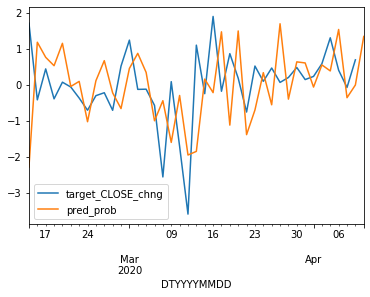

In [264]:
res_std[['target_CLOSE_chng', 'pred_prob']].plot()

In [335]:
df = df_merged.copy()

In [336]:
df.loc[:,'pred_class'] = model.predict(df[train_cols])
df.loc[:,'pred_prob'] = model.predict_proba(df[train_cols])[:,1]

df.loc[:,'fut_OPEN'] = df.loc[:,'OPEN'].shift(-1)
df.loc[:,'target_OPEN_chng'] = (df.loc[:,'fut_OPEN'] * 100 / df.loc[:,'CLOSE']) - 100
df.loc[:,'target_HIGH_chng'] = df.loc[:,'chng_HIGH'].shift(-1).copy()
df.loc[:,'target_CLOSE_chng'] = df.loc[:,'chng_CLOSE'].shift(-1).copy()

In [340]:
res = df.reset_index()

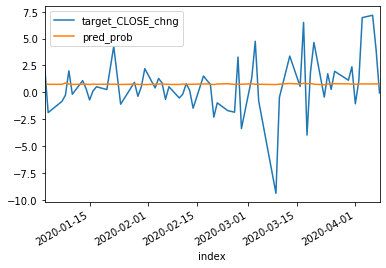

In [354]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.7), :].groupby(['index']).mean()[['target_CLOSE_chng', 'pred_prob']].plot()

In [360]:
res.loc[(res.loc[:,'index'] > '2020-01-01')
        & (res.pred_prob > 0.8), :].groupby(['index']).mean()[
    ['target_HIGH_chng','target_CLOSE_chng', 'pred_prob']].median()

target_HIGH_chng     0.202429
target_CLOSE_chng    0.887612
pred_prob            0.833990
dtype: float64

In [355]:
res.sort_values('pred_prob', ascending=False).head(100)

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
199145,2011-08-11,PGE,17.85,19.250,17.6500,19.250,6.587300e+06,19.150,-6.788512,17.2400,...,1.0,2.857047,5.404341,-0.952958,1.0,0.967548,949.240,4831.116883,-6.512986,9.040890
541326,2020-03-19,WIG20LEV,228.15,248.410,221.7200,248.410,9.736780e+05,234.310,-2.628996,218.3100,...,1.0,1.330692,7.141789,-5.605968,1.0,0.960654,16.400,-93.398011,-4.576659,1.863354
541325,2020-03-19,PGE,3.65,4.036,3.6200,4.036,7.531181e+06,3.520,3.693182,3.3500,...,1.0,1.330692,7.141789,-5.605968,1.0,0.957879,228.150,5552.874133,0.327141,9.721731
199146,2011-08-11,WIG20LEV,949.24,1014.680,863.6800,1014.680,1.683095e+06,1071.960,-11.448188,878.6300,...,1.0,2.857047,5.404341,-0.952958,1.0,0.955207,84.500,-91.672251,-2.526316,4.360465
541313,2020-03-19,CCC,26.00,29.780,25.4000,29.600,2.128518e+06,26.840,-3.129657,24.3000,...,1.0,1.330692,7.141789,-5.605968,1.0,0.954583,3.000,-89.864865,-3.225806,-3.333333
540604,2020-03-13,LOTOS,42.04,45.900,39.8200,44.990,8.754780e+05,40.500,3.802469,39.0000,...,0.0,3.955261,13.908829,-6.080832,1.0,0.954446,1.870,-95.843521,-2.777778,-2.551020
202290,2011-09-15,CDPROJEKT,3.72,3.950,3.7200,3.950,8.404720e+05,3.650,1.917808,3.6200,...,1.0,1.349585,3.271462,-0.332003,1.0,0.952014,2.520,-36.202532,2.325581,4.761905
540955,2020-03-17,CIGAMES,0.41,0.436,0.4000,0.436,2.820567e+06,0.374,9.625668,0.3370,...,1.0,3.179108,13.518576,-3.209159,1.0,0.950566,10.000,2193.577982,-11.297071,0.200401
541403,2020-03-19,WIG30,1631.13,1712.070,1617.3100,1712.070,1.033160e+06,1635.080,-0.241578,1598.5800,...,1.0,1.330692,7.141789,-5.605968,1.0,0.949328,2977.070,73.887166,3.295832,5.038784
540924,2020-03-17,MABION,25.00,31.000,25.0000,31.000,9.760700e+04,20.000,25.000000,18.5000,...,1.0,3.179108,13.518576,-3.209159,1.0,0.947911,4.960,-84.000000,3.488372,6.024096


In [363]:
res.loc[res.pred_prob > 0.7].mean()

OPEN                    694.408521
HIGH                    706.094534
LOW                     691.763361
CLOSE                   705.061505
VOL                  479465.474154
                         ...      
pred_prob                 0.756463
fut_OPEN                361.378365
target_OPEN_chng       3284.682078
target_HIGH_chng          0.329685
target_CLOSE_chng         0.637524
Length: 276, dtype: float64

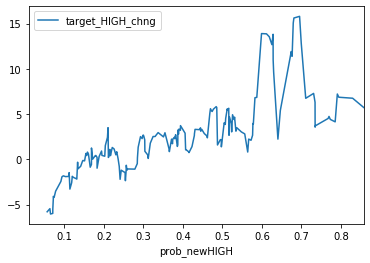

In [162]:
res.loc[:,['target_HIGH_chng', 'prob_newHIGH']]\
.sort_values('prob_newHIGH').set_index('prob_newHIGH').rolling(7).mean().plot()

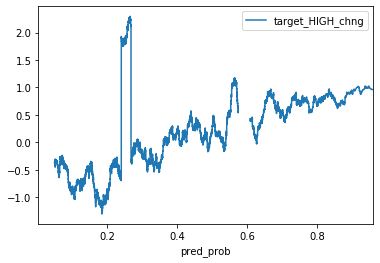

In [375]:
res.loc[res.loc[:,'index'] > '2020-01-01',['target_HIGH_chng', 'pred_prob']]\
.sort_values('pred_prob').set_index('pred_prob').rolling(500).mean().plot()

In [378]:
res.loc[res.loc[:,'index'] > '2020-04-07',:]

,index,TICKER,OPEN,HIGH,LOW,CLOSE,VOL,OPEN_shifted,chng_OPEN,LOW_shifted,...,target,foreign_stocks_mean,foreign_stocks_max,foreign_stocks_min,pred_class,pred_prob,fut_OPEN,target_OPEN_chng,target_HIGH_chng,target_CLOSE_chng
543985,2020-04-08,EFEKT,3.16,3.38,2.86,3.24,21180.0,2.58,22.480620,2.54,...,0.0,1.66631,5.106485,-1.166522,0.0,0.403466,25.70,693.209877,-9.507042,-7.692308
543986,2020-04-08,MABION,25.70,25.70,23.40,24.00,75002.0,28.40,-9.507042,25.65,...,0.0,1.66631,5.106485,-1.166522,0.0,0.242316,2.35,-90.208333,-1.673640,-10.638298
543987,2020-04-08,ELBUDOWA,2.35,2.35,1.91,2.10,129473.0,2.35,0.000000,2.18,...,0.0,1.66631,5.106485,-1.166522,0.0,0.113428,33.50,1495.238095,-10.053476,0.240964
543988,2020-04-08,CCC,33.50,33.64,31.50,33.28,521253.0,35.40,-5.367232,33.20,...,1.0,1.66631,5.106485,-1.166522,1.0,0.599440,2.94,-91.165865,-2.000000,-5.172414
543989,2020-04-08,SOLAR,2.94,2.94,2.65,2.75,10255.0,2.59,13.513514,2.48,...,0.0,1.66631,5.106485,-1.166522,0.0,0.181260,10.20,270.909091,-7.488987,-3.921569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544174,2020-04-08,EVEREST,7.20,7.20,7.00,7.20,1030.0,7.50,-4.000000,7.00,...,0.0,1.66631,5.106485,-1.166522,0.0,0.498369,8.00,11.111111,-0.934579,22.401848
544175,2020-04-08,PHARMENA,8.00,10.60,7.28,10.60,20106.0,10.50,-23.809524,8.52,...,1.0,1.66631,5.106485,-1.166522,1.0,0.701910,3.13,-70.471698,-24.074074,0.000000
544176,2020-04-08,BIOMEDLUB,3.13,4.10,2.64,3.40,9752784.0,5.10,-38.627451,3.33,...,1.0,1.66631,5.106485,-1.166522,1.0,0.529845,3.30,-2.941176,-13.157895,-5.120482
544177,2020-04-08,HARPER,3.30,3.30,2.97,3.15,164611.0,3.70,-10.810811,3.21,...,0.0,1.66631,5.106485,-1.166522,0.0,0.337076,0.27,-91.428571,-3.571429,-3.571429


#### Regression

In [103]:
df.loc[:, 'preds'] = model.predict(df[train_cols])

In [104]:
df.loc[:,['target', 'preds', 'OPEN', 'CLOSE']]

,target,preds,OPEN,CLOSE
DTYYYYMMDD,,,,
2017-07-27,0.027887,0.405700,36.00,35.50
2017-07-28,0.016772,0.115789,35.50,36.25
2017-07-31,0.012212,0.110641,36.37,36.80
2017-08-01,0.024067,0.119130,36.85,36.89
2017-08-02,0.013740,0.046849,36.98,36.50
...,...,...,...,...
2020-04-02,0.049110,0.034687,28.40,28.56
2020-04-03,0.036328,0.037045,28.10,29.48
2020-04-06,0.033443,0.032499,30.28,29.86


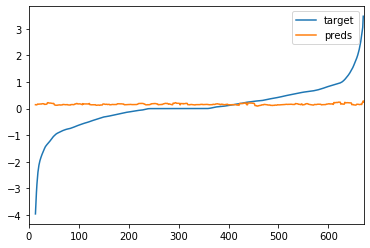

In [220]:
df.sort_values('target').reset_index()[['target', 'preds']].rolling(14).mean().plot()

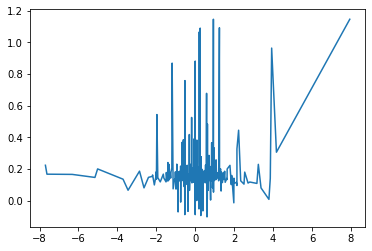

In [210]:
plt.plot(df.sort_values('target').target, df.sort_values('target').preds)

In [191]:
for c in ['preds', 'target']:
    df.loc[df.loc[:, c] > 0, c] = 1
    df.loc[df.loc[:, c] < 1, c] = 0

In [195]:
confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int))

array([[  6, 351],
       [  6, 308]])

In [196]:
tn, fp, fn, tp = confusion_matrix(df.target[:-1].astype(int), df.preds[:-1].astype(int)).ravel()
(tn, fp, fn, tp)

(6, 351, 6, 308)

In [198]:
df.preds

DTYYYYMMDD
2017-07-27    1.0
2017-07-28    1.0
2017-07-31    1.0
2017-08-01    1.0
2017-08-02    1.0
             ... 
2020-04-02    1.0
2020-04-03    1.0
2020-04-06    1.0
2020-04-07    1.0
2020-04-08    0.0
Name: preds, Length: 672, dtype: float64

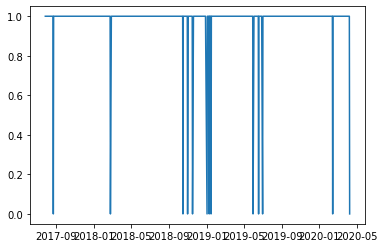

In [197]:
plt.plot(df.preds)

In [ ]:
df_res.loc[:,'one'] = df_res.loc[:,'one'].round(2)
df_res.loc[:,'zero'] = df_res.loc[:,'zero'].round(2)

df_res_grouped = df_res.drop('zero', axis = 1)

df_res_grouped.loc[df_res_grouped.one <= 0.3,'one'] = 0.3

# df_res_grouped.loc[df_res_grouped.one >= 0.54,'one'] = 0.54

df_res_grouped = df_res_grouped.groupby('one').agg(['mean', 'count'])

df_res_grouped.columns = df_res_grouped.columns.get_level_values(1)

df_res_grouped = df_res_grouped.reset_index().set_index('one')

df_res_grouped.plot(secondary_y='count')
plt.xticks(rotation=60)
plt.show()

df_res_grouped

## Foreign indexes

## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
